# Building Better Features for Recession Prediction

Now that we've explored our data, it's time to get it ready for machine learning. We'll clean up missing values, create some lag variables (because economic indicators often predict the future), and normalize everything so our model doesn't get confused by different scales.

In [1]:
# Import notebook utilities
from notebook_utils import init_notebook, load_data, display_data_info, save_figure
import os
import numpy as np
import matplotlib.pyplot as plt

# Initialize notebook environment
init_notebook()

# Import from econ_downturn package
from econ_downturn import engineer_features, normalize_data, apply_pca

Initializing notebook environment...
✓ Added c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\src to Python path
✓ econ_downturn package imported successfully
✓ Notebook environment configured
✓ Environment variables loaded

Available data paths:
  fred_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred
  nber_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\nber
  processed_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed
  fred_all_indicators: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred\all_indicators.csv
  nber_recession_indicator: c:\Users\Admin\e

## Loading Our Clean Dataset

Let's grab the merged dataset we put together in our exploration phase.

In [2]:
# Load all data using the utility function
merged_data = load_data(use_cached=True)

# Display information about the dataset
display_data_info(merged_data)

Loading cached merged data from c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed\merged_data.csv
2025-07-06 13:42:58,034 - econ_downturn.data.data_loader - INFO - Loaded merged data with shape: (15657, 13)
Loaded merged data with shape: (15657, 13)
Dataset Information:
Time Range: 1970-01-01 00:00:00 to 2024-05-31 00:00:00
Number of Observations: 15657
Number of Features: 13

Summary Statistics:


,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,recession,SENTIMENT,INFLATION_EXPECTATION
count,218.000000,653.000000,653.000000,653.000000,11998.000000,2.839000e+03,653.000000,389.000000,653.000000,589.000000,653.000000,589.000000,557.000000
mean,12837.776711,6.110260,158.663954,4.910490,0.868401,3.733381e+05,74.982246,365237.385604,1435.917305,84.583531,0.128637,84.583531,3.590126
std,5217.489014,1.709394,73.783619,3.898737,0.925610,2.450608e+05,22.585732,138188.557313,410.165486,13.111529,0.335054,13.111529,1.625392
min,5299.672000,3.400000,37.900000,0.050000,-2.410000,1.890000e+05,36.388100,158647.000000,478.000000,50.000000,0.000000,50.000000,0.400000
25%,7760.008000,4.900000,100.100000,1.510000,0.190000,3.010000e+05,51.806000,264067.000000,1176.000000,74.300000,0.000000,74.300000,2.800000
50%,12216.346500,5.800000,159.800000,5.050000,0.830000,3.460000e+05,78.919700,349869.000000,1465.000000,88.200000,0.000000,88.200000,3.000000
75%,16937.626250,7.200000,219.035000,6.890000,1.500000,4.020000e+05,97.606000,443117.000000,1698.000000,94.200000,0.000000,94.200000,3.500000
max,23223.906000,14.800000,313.140000,19.100000,2.910000,6.137000e+06,104.103800,692635.000000,2494.000000,112.000000,1.000000,112.000000,10.400000



Missing Values:


,Missing Values,Percentage
GDP,15439,98.607652
RETAIL_SALES,15268,97.515488
INFLATION_EXPECTATION,15100,96.442486
SENTIMENT,15068,96.238104
CONSUMER_SENTIMENT,15068,96.238104
INDUSTRIAL_PROD,15004,95.829342
FED_FUNDS,15004,95.829342
CPI,15004,95.829342
UNEMPLOYMENT,15004,95.829342
recession,15004,95.829342


## Creating Smart Features

Our goal here is to transform raw indicators related to economic recession into informative inputs. engineer_features as a function will automate this process, generating lagging variables, moving averages, and other general transformations to capture indicator change over time.

The engineered features displayed here are made to reflect the time-dependent aspect of economic signals. To use an example, a spike in unemployment could not indiciate a recession today, but could indicate one months later on. Through our inclusion of lagged indicator versions, our model is allowed to detect such delays. This results in a richer and more predictive dataset that reflects not only short-term shifts, but longer term trends that enhance our conclusions.

The engineer_features function:

1. Creates lagged versions of macroeconomic indicators.

2. Calculates percentage changes over time to quantify shifts.

3. Combines existing features (e.g. GPD & Unemployment) to measure joint effects.

In [3]:
# Engineer features using the package function
data_with_features = engineer_features(merged_data)

print(f"Data shape after feature engineering: {data_with_features.shape}")
print(f"Number of features: {data_with_features.shape[1]}")

# Display the first few rows of the engineered data
display(data_with_features.head())

2025-07-06 13:42:58,085 - econ_downturn.features.feature_engineering - WARNING - There are still 15004 missing values after handling
2025-07-06 13:42:58,094 - econ_downturn.features.feature_engineering - INFO - Resampled data to M frequency, new shape: (653, 13)
2025-07-06 13:42:58,104 - econ_downturn.features.feature_engineering - INFO - Created lag variables with periods [1, 3, 6, 12], new shape: (653, 61)
2025-07-06 13:42:58,123 - econ_downturn.features.feature_engineering - INFO - Calculated rate of change with periods [1, 3, 12], new shape: (653, 97)
2025-07-06 13:42:58,125 - econ_downturn.features.feature_engineering - INFO - Dropped rows with missing values, new shape: (635, 97)
2025-07-06 13:42:58,126 - econ_downturn.features.feature_engineering - INFO - Completed feature engineering, final shape: (635, 97)
Data shape after feature engineering: (635, 97)
Number of features: 97


,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,SENTIMENT,INFLATION_EXPECTATION,GDP_lag1,GDP_lag3,GDP_lag6,GDP_lag12,UNEMPLOYMENT_lag1,UNEMPLOYMENT_lag3,UNEMPLOYMENT_lag6,UNEMPLOYMENT_lag12,CPI_lag1,CPI_lag3,CPI_lag6,CPI_lag12,FED_FUNDS_lag1,FED_FUNDS_lag3,FED_FUNDS_lag6,FED_FUNDS_lag12,YIELD_CURVE_lag1,YIELD_CURVE_lag3,YIELD_CURVE_lag6,YIELD_CURVE_lag12,INITIAL_CLAIMS_lag1,INITIAL_CLAIMS_lag3,INITIAL_CLAIMS_lag6,INITIAL_CLAIMS_lag12,INDUSTRIAL_PROD_lag1,INDUSTRIAL_PROD_lag3,INDUSTRIAL_PROD_lag6,INDUSTRIAL_PROD_lag12,RETAIL_SALES_lag1,RETAIL_SALES_lag3,RETAIL_SALES_lag6,RETAIL_SALES_lag12,HOUSING_STARTS_lag1,HOUSING_STARTS_lag3,HOUSING_STARTS_lag6,HOUSING_STARTS_lag12,CONSUMER_SENTIMENT_lag1,CONSUMER_SENTIMENT_lag3,CONSUMER_SENTIMENT_lag6,CONSUMER_SENTIMENT_lag12,SENTIMENT_lag1,SENTIMENT_lag3,SENTIMENT_lag6,SENTIMENT_lag12,INFLATION_EXPECTATION_lag1,INFLATION_EXPECTATION_lag3,INFLATION_EXPECTATION_lag6,INFLATION_EXPECTATION_lag12,GDP_pct_change_1,GDP_pct_change_3,GDP_pct_change_12,UNEMPLOYMENT_pct_change_1,UNEMPLOYMENT_pct_change_3,UNEMPLOYMENT_pct_change_12,CPI_pct_change_1,CPI_pct_change_3,CPI_pct_change_12,FED_FUNDS_pct_change_1,FED_FUNDS_pct_change_3,FED_FUNDS_pct_change_12,YIELD_CURVE_pct_change_1,YIELD_CURVE_pct_change_3,YIELD_CURVE_pct_change_12,INITIAL_CLAIMS_pct_change_1,INITIAL_CLAIMS_pct_change_3,INITIAL_CLAIMS_pct_change_12,INDUSTRIAL_PROD_pct_change_1,INDUSTRIAL_PROD_pct_change_3,INDUSTRIAL_PROD_pct_change_12,RETAIL_SALES_pct_change_1,RETAIL_SALES_pct_change_3,RETAIL_SALES_pct_change_12,HOUSING_STARTS_pct_change_1,HOUSING_STARTS_pct_change_3,HOUSING_STARTS_pct_change_12,CONSUMER_SENTIMENT_pct_change_1,CONSUMER_SENTIMENT_pct_change_3,CONSUMER_SENTIMENT_pct_change_12,SENTIMENT_pct_change_1,SENTIMENT_pct_change_3,SENTIMENT_pct_change_12,INFLATION_EXPECTATION_pct_change_1,INFLATION_EXPECTATION_pct_change_3,INFLATION_EXPECTATION_pct_change_12,recession
1971-01-31,5443.619,5.9,39.9,4.14,0.68,292000.0,37.5101,159177.0,1828.0,72.4,72.4,5.2,5299.672,5299.672,5357.077,5300.652,6.1,5.5,5.0,3.9,39.8,39.4,38.9,37.9,4.90,6.20,7.21,8.98,0.68,0.68,0.68,0.68,321000.0,327000.0,287000.0,239000.0,37.2237,36.6098,37.6836,37.9288,159177.0,159177.0,159177.0,159177.0,1893.0,1580.0,1517.0,1085.0,72.4,77.6,75.4,78.1,72.4,77.6,75.4,78.1,5.2,5.2,5.2,5.2,0.027161,0.027161,0.026972,-0.032787,0.072727,0.512821,0.002513,0.012690,0.052770,-0.155102,-0.332258,-0.538976,0.0,0.0,0.0,-0.090343,-0.107034,0.221757,0.007694,0.024592,-0.011039,0.0,0.0,0.0,-0.034337,0.156962,0.684793,0.000000,-0.067010,-0.072983,0.000000,-0.067010,-0.072983,0.0,0.0,0.0,0.0
1971-02-28,5443.619,5.9,39.9,3.72,0.68,290000.0,37.4386,159177.0,1741.0,78.1,78.1,5.2,5443.619,5299.672,5357.077,5300.652,5.9,5.9,5.1,4.2,39.9,39.6,39.0,38.1,4.14,5.60,6.62,8.98,0.68,0.68,0.68,0.68,292000.0,337000.0,297000.0,242000.0,37.5101,36.3881,37.6164,37.9038,159177.0,159177.0,159177.0,159177.0,1828.0,1647.0,1399.0,1305.0,72.4,72.4,77.6,78.1,72.4,72.4,77.6,78.1,5.2,5.2,5.2,5.2,0.000000,0.027161,0.026972,0.000000,0.000000,0.404762,0.000000,0.007576,0.047244,-0.101449,-0.335714,-0.585746,0.0,0.0,0.0,-0.006849,-0.139466,0.198347,-0.001906,0.028869,-0.012273,0.0,0.0,0.0,-0.047593,0.057073,0.334100,0.078729,0.078729,0.000000,0.078729,0.078729,0.000000,0.0,0.0,0.0,0.0
1971-03-31,5443.619,6.0,40.0,3.71,0.68,300000.0,37.3980,159177.0,1910.0,78.1,78.1,5.2,5443.619,5299.672,5357.077,5300.652,5.9,6.1,5.4,4.4,39.9,39.8,39.2,38.3,3.72,4.90,6.29,7.76,0.68,0.68,0.68,0.68,290000.0,321000.0,333000.0,276000.0,37.4386,37.2237,37.3571,37.8546,159177.0,159177.0,159177.0,159177.0,1741.0,1893.0,1534.0,1319.0,78.1,72.4,77.6,78.1,78.1,72.4,77.6,78.1,5.2,5.2,5.2,5.2,0.000000,0.027161,0.026972,0.016949,-0.016393,0.363636,0.002506,0.005025,0.044386,-0.002688,-0.242857,-0.521907,0.0,0.0,0.0,0.034483,-0.065421,0.086957,-0.001084,0.004683,-0.012062,0.0,0.0,0.0,0.097071,0.008980,0.448067,0.000000,0.078729,0.000000,0.000000,0.078729,0.000000,0.0,0.0,0.0,0.0

## Getting Everything on the Same Scale

An initial limitation of the data we selected for analysis was the scale variance. These indicators have wildly different scales. For instance, unemployment rate might be 5% while GDP is in the trillions. Since these numeric metrics need to be fairly weighted and added together, it is crucial that we normalize the scale before building the MDA model. If we were to leave features unscaled, variables with larger numeric values would dominate the learning process.

To avoid this, we will normalize the entire merged dataset using the normalize_data() function from our utility code. This rescales all our features to give them similar influence on an MDA model. Our normalized output preserves the original data structure while giving each variable equal influence.

With our normalize_data function:

1. A scaler is created to standardize the features.

2. This scaler is fit onto our data and transforms all feature columns.

3. The new DataFrame is saved in the data_normalized variable for future use.

In [4]:
# Normalize the data
data_normalized, scaler = normalize_data(data_with_features)

print(f"Data shape after normalization: {data_normalized.shape}")

# Display the first few rows of the normalized data
display(data_normalized.head())

2025-07-06 13:42:58,189 - econ_downturn.features.normalization - INFO - Normalized data using standard method, shape: (635, 97)
Data shape after normalization: (635, 97)


,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,SENTIMENT,INFLATION_EXPECTATION,GDP_lag1,GDP_lag3,GDP_lag6,GDP_lag12,UNEMPLOYMENT_lag1,UNEMPLOYMENT_lag3,UNEMPLOYMENT_lag6,UNEMPLOYMENT_lag12,CPI_lag1,CPI_lag3,CPI_lag6,CPI_lag12,FED_FUNDS_lag1,FED_FUNDS_lag3,FED_FUNDS_lag6,FED_FUNDS_lag12,YIELD_CURVE_lag1,YIELD_CURVE_lag3,YIELD_CURVE_lag6,YIELD_CURVE_lag12,INITIAL_CLAIMS_lag1,INITIAL_CLAIMS_lag3,INITIAL_CLAIMS_lag6,INITIAL_CLAIMS_lag12,INDUSTRIAL_PROD_lag1,INDUSTRIAL_PROD_lag3,INDUSTRIAL_PROD_lag6,INDUSTRIAL_PROD_lag12,RETAIL_SALES_lag1,RETAIL_SALES_lag3,RETAIL_SALES_lag6,RETAIL_SALES_lag12,HOUSING_STARTS_lag1,HOUSING_STARTS_lag3,HOUSING_STARTS_lag6,HOUSING_STARTS_lag12,CONSUMER_SENTIMENT_lag1,CONSUMER_SENTIMENT_lag3,CONSUMER_SENTIMENT_lag6,CONSUMER_SENTIMENT_lag12,SENTIMENT_lag1,SENTIMENT_lag3,SENTIMENT_lag6,SENTIMENT_lag12,INFLATION_EXPECTATION_lag1,INFLATION_EXPECTATION_lag3,INFLATION_EXPECTATION_lag6,INFLATION_EXPECTATION_lag12,GDP_pct_change_1,GDP_pct_change_3,GDP_pct_change_12,UNEMPLOYMENT_pct_change_1,UNEMPLOYMENT_pct_change_3,UNEMPLOYMENT_pct_change_12,CPI_pct_change_1,CPI_pct_change_3,CPI_pct_change_12,FED_FUNDS_pct_change_1,FED_FUNDS_pct_change_3,FED_FUNDS_pct_change_12,YIELD_CURVE_pct_change_1,YIELD_CURVE_pct_change_3,YIELD_CURVE_pct_change_12,INITIAL_CLAIMS_pct_change_1,INITIAL_CLAIMS_pct_change_3,INITIAL_CLAIMS_pct_change_12,INDUSTRIAL_PROD_pct_change_1,INDUSTRIAL_PROD_pct_change_3,INDUSTRIAL_PROD_pct_change_12,RETAIL_SALES_pct_change_1,RETAIL_SALES_pct_change_3,RETAIL_SALES_pct_change_12,HOUSING_STARTS_pct_change_1,HOUSING_STARTS_pct_change_3,HOUSING_STARTS_pct_change_12,CONSUMER_SENTIMENT_pct_change_1,CONSUMER_SENTIMENT_pct_change_3,CONSUMER_SENTIMENT_pct_change_12,SENTIMENT_pct_change_1,SENTIMENT_pct_change_3,SENTIMENT_pct_change_12,INFLATION_EXPECTATION_pct_change_1,INFLATION_EXPECTATION_pct_change_3,INFLATION_EXPECTATION_pct_change_12,recession
1971-01-31,-1.461327,-0.140083,-1.664270,-0.185182,-0.199809,-0.304849,-1.717118,-0.848125,0.944882,-0.903522,-0.903522,0.862987,-1.486073,-1.478791,-1.458195,-1.44965,-0.023535,-0.380060,-0.683463,-1.340000,-1.661903,-1.659973,-1.655766,-1.647170,0.008967,0.340239,0.596001,1.033978,-0.201645,-0.20497,-0.209752,-0.225602,-0.201553,-0.180790,-0.329633,-0.502389,-1.723420,-1.737373,-1.670647,-1.623891,-0.847102,-0.844908,-0.842085,-0.83752,1.099105,0.340965,0.190319,-0.848128,-0.904985,-0.503004,-0.669966,-0.474315,-0.904985,-0.503004,-0.669966,-0.474315,0.861373,0.856394,0.849865,0.83681,3.482761,1.919535,-0.045758,-0.351595,0.354379,1.737546,-0.214864,0.346434,0.431095,-1.154951,-0.760906,-0.261464,-0.051511,-0.022756,-0.031757,-0.122363,-0.146673,0.082112,0.631829,1.032037,-0.671179,-0.1709,-0.317676,-0.63709,-0.456526,1.386494,2.965761,-0.021041,-0.818392,-0.584002,-0.021041,-0.818392,-0.584002,-0.050235,-0.066752,-0.076352,0.0
1971-02-28,-1.461327,-0.140083,-1.664270,-0.292468,-0.199809,-0.311959,-1.720338,-0.848125,0.734989,-0.464391,-0.464391,0.862987,-1.457972,-1.478791,-1.458195,-1.44965,-0.140749,-0.142873,-0.624656,-1.162766,-1.660523,-1.657206,-1.654377,-1.644371,-0.185082,0.187116,0.445637,1.033978,-0.201645,-0.20497,-0.209752,-0.225602,-0.305208,-0.144734,-0.294116,-0.491726,-1.710535,-1.747318,-1.673654,-1.625005,-0.847102,-0.844908,-0.842085,-0.83752,0.942459,0.502545,-0.094068,-0.318212,-0.904985,-0.903554,-0.500104,-0.474315,-0.904985,-0.903554,-0.500104,-0.474315,0.861373,0.856394,0.849865,0.83681,-0.328164,1.919535,-0.045758,-0.020520,-0.036258,1.356231,-0.970297,-0.256248,0.243669,-0.781927,-0.767625,-0.271137,-0.051511,-0.022756,-0.031757,-0.043565,-0.173933,0.064850,-0.365930,1.255782,-0.697500,-0.1709,-0.317676,-0.63709,-0.618576,0.478303,1.391286,1.488259,0.868733,-0.061194,1.488259,0.868733,-0.061194,-0.050235,-0.066752,-0.076352,0.0
1971-03-31,-1.461327,-0.081715,-1.662891,-0.295022,-0.199809,-0.276413,-1.722167,-0.848125,1.142713,-0.464391,-0.464391,0.862987,-1.457972,-1.4

## Reducing Complexity with PCA

Next, we will use Principal Component Analysis (aka PCA) to reduce the dimensionality of our dataset. The ultimate goal is to simply the feature space listed while keeping the most important information. This step will help reduce any noise, redundancy, or multicollinearity reflected in the current merged dataset. We hope this feature simplification will improve the performance of our MDA model.

There are a few important steps to note in this section:

1. Seperating the target variable:

    We removed the recession indicator column in order to only apply PCA to the predictor variable.


2. Applying PCA:

    Principal Component Analysis transforms our original features into a set of uncorrelated features that are called principal components. Each of these components is a combination of the original variables and captures a portion of overall dataset variance. We are essentially telling PCA to retain enough of these components to explain 95% of the whole variance, keeping the useful indicators while dropping less useful patterns.


3. Understanding the Output:

    We have created a new dataset with these principal components and added the recession indicator back into it for future modeling. This final dataset has less columns than the original merged dataset, but retains nearly all the important statistical patterns.
    

4. Our Plot:

    The code outputs a bar chart and line graph to show how much variance is captured by each principal component. To explain the roles of each, the bar chart shows individual contributions of each comoponent, while the line shows the cumulative total. This is a visual way to verify that we retained all the critical information necessary.

2025-07-06 13:42:58,269 - econ_downturn.features.normalization - INFO - Applied PCA retaining 95.0% of variance
2025-07-06 13:42:58,270 - econ_downturn.features.normalization - INFO - Number of PCA components: 27
2025-07-06 13:42:58,270 - econ_downturn.features.normalization - INFO - Cumulative explained variance: 0.9535
Data shape after PCA: (635, 27)
Number of PCA components: 26
Cumulative explained variance: 0.9535


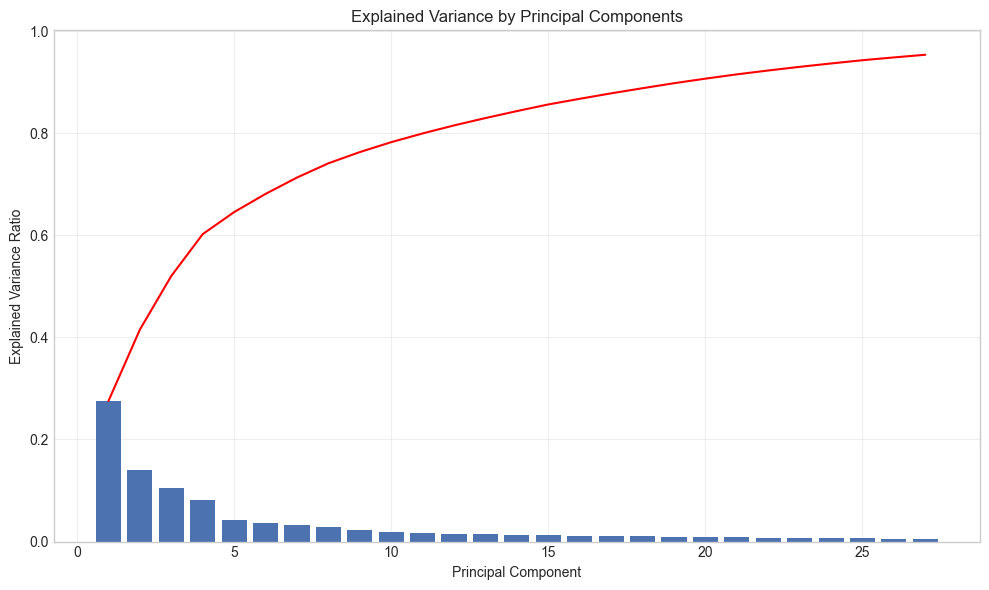

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\pca_explained_variance.png


<Figure size 1200x800 with 0 Axes>

In [5]:
# Separate features and target
X = data_normalized.drop(columns=['recession'])
y = data_normalized['recession']

# Apply PCA
X_pca_df, pca = apply_pca(X, n_components=0.95)

# Calculate explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"Data shape after PCA: {X_pca_df.shape}")
print(f"Number of PCA components: {X_pca_df.shape[1] - 1}")  # Subtract 1 for target column
print(f"Cumulative explained variance: {explained_variance:.4f}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save the figure
save_figure(plt.gcf(), "pca_explained_variance.png")

## Saving Our Work

After our process of prepping data through feature engineering, normalization, and PCA, we save each version of the dataset to files. We can cleanly reuse these three new datasets in our modeling steps without repeating processing lines.

Specifically, we save:

1. Data with Features:

    This is our basic transformed data, including all original indicators with the engineered lagged and smoothed variables.


2. Normalized Data:

    As discussed earlier, putting each of our macroeconomic indicators on the same numeric scale is key for our PCA and MDA steps. This data is ready to be fed into our PCA step.


3. PCA Data:

    This saved file will include only the principal components identified from PCA, as well as the target recession indicator. This is the most compact and analysis-ready version of our data, and is optimized for training our MDA model.


Saving these for later use will cleanly consolidate our future steps by allowing us to easily import transformed data to model.

In [6]:
# Get data paths for saving processed data
from econ_downturn import get_data_paths
data_paths = get_data_paths()
output_dir = data_paths['processed_dir']
os.makedirs(output_dir, exist_ok=True)

# Save the dataset with features
data_path = os.path.join(output_dir, 'data_with_features.csv')
data_with_features.to_csv(data_path)
print(f"Saved dataset with features to {data_path}")

# Save the normalized dataset
normalized_path = os.path.join(output_dir, 'data_normalized.csv')
data_normalized.to_csv(normalized_path)
print(f"Saved normalized dataset to {normalized_path}")

# Save the PCA dataset
pca_path = os.path.join(output_dir, 'data_pca.csv')
X_pca_df.to_csv(pca_path)
print(f"Saved PCA dataset to {pca_path}")

Saved dataset with features to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed\data_with_features.csv
Saved normalized dataset to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed\data_normalized.csv
Saved PCA dataset to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed\data_pca.csv
